In [44]:
import tensorflow as tf
from keras.datasets import cifar100
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense, Activation, Lambda
from tensorflow.keras.models import Model
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import datetime, os
import time
import pandas as pd
import seaborn as sns

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
#Load dataset
(X_c_train, y_c_train), (X_c_test, y_c_test) = cifar100.load_data(label_mode='coarse')
(X_f_train, y_f_train), (X_f_test, y_f_test) = cifar100.load_data(label_mode='fine')

X_train = X_f_train
X_val = X_f_test[:5000]
X_test = X_f_test[5000:]

y_train = [y_c_train, y_f_train]
y_val = [y_c_test[:5000], y_f_test[:5000]]
y_test = [y_c_test[5000:], y_f_test[5000:]]

image_size = X_train[0].shape

num_classes_c = len(set([v[0] for v in y_c_train]))
num_classes_f = len(set([v[0] for v in y_f_train]))



In [35]:
class global_accuracy(keras.callbacks.Callback):
    """
    Each `SquadExample` object contains the character level offsets for each token
    in its input paragraph. We use them to get back the span of text corresponding
    to the tokens between our predicted start and end tokens.
    All the ground-truth answers are also present in each `SquadExample` object.
    We calculate the percentage of data points where the span of text obtained
    from model predictions matches one of the ground-truth answers.
    """

    def __init__(self, x_eval, y_eval):
        self.x_eval = x_eval
        self.y_eval = y_eval

    def on_epoch_end(self, epoch, logs=None):
      accuracy, accuracy_c, accuracy_f = get_metrics(self.model, self.x_eval, self.y_eval)

      accuracy_ci = 1.96 * np.std(accuracy) / np.sqrt(len(accuracy))
      accuracy = np.mean(accuracy)
      
      accuracy_c_ci = 1.96 * np.std(accuracy_c) / np.sqrt(len(accuracy_c))
      accuracy_c = np.mean(accuracy_c)
      
      accuracy_f_ci = 1.96 * np.std(accuracy_f) / np.sqrt(len(accuracy_f))
      accuracy_f = np.mean(accuracy_f)


      print('-'*100)
      print(f"epoch={epoch+1}, global accuracy = {accuracy:.4f}±{accuracy_ci:.4f}, accuracy_c = {accuracy_c:.4f}±{accuracy_c_ci:.4f}, accuracy_f = {accuracy_f:.4f}±{accuracy_f_ci:.4f}")
      print('-'*100)
      print('')

def get_metrics(model, X, y):
  pred_c, pred_f = model.predict(X)
  accuracy = []
  accuracy_c = []
  accuracy_f = []
  for idx, (c, f) in enumerate(zip(pred_c, pred_f)):
    c = np.argmax(c)
    f = np.argmax(f)
    if y[0][idx][0] == c and y[1][idx][0] == f:
      accuracy.append(1)
      accuracy_c.append(1)
      accuracy_f.append(1)
    elif y[0][idx][0] == c and y[1][idx][0] != f:
      accuracy.append(0)
      accuracy_c.append(1)
      accuracy_f.append(0)
    elif y[0][idx][0] != c and y[1][idx][0] == f:
      accuracy.append(0)
      accuracy_c.append(0)
      accuracy_f.append(1)
    else:
      accuracy.append(0)
      accuracy_c.append(0)
      accuracy_f.append(0)    
  
  return accuracy, accuracy_c, accuracy_f
  


Model: "Model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten (Flatten)               (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
out_c (Dense)                   (None, 20)           10260       flatten[0][0]                    
____________________________________________________________________________________________

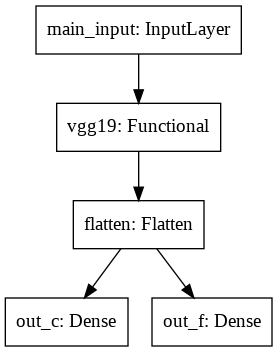

In [4]:
def get_model1(pi=0.5):
    # Conv base
    in_layer = Input(shape=image_size, name='main_input')
    conv_base = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")(in_layer)
    conv_base = Flatten()(conv_base)
    # coarse output
    out_c = Dense(num_classes_c, activation="softmax", name='out_c')(conv_base)
    # fine output 
    out_f = Dense(num_classes_f, activation="softmax", name='out_f')(conv_base)
    # Build the model
    model = Model(name='Model_1',
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[1-pi, pi],
                  metrics=['accuracy'])
    return model

model = get_model1()
model.summary()
plot_model(model)

Model: "Model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
out_c (Dense)                (None, 20)                10260     
_________________________________________________________________
out_f (Dense)                (None, 100)               2100      
Total params: 20,036,744
Trainable params: 20,036,744
Non-trainable params: 0
_________________________________________________________________


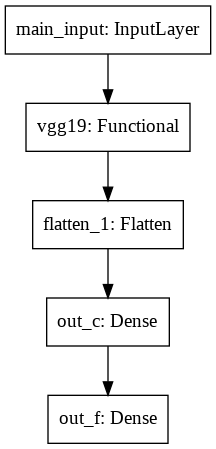

In [5]:
def get_model2(pi=0.5):
    # Conv base
    in_layer = Input(shape=image_size, name='main_input')
    conv_base = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")(in_layer)
    conv_base = Flatten()(conv_base)
    # coarse output
    out_c = Dense(num_classes_c, activation="softmax", name='out_c')(conv_base)
    # fine output 
    out_f = Dense(num_classes_f, activation="softmax", name='out_f')(out_c)
    # Build the model
    model = Model(name='Model_2',
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[1-pi, pi],
                  metrics=['accuracy'])
    return model

model = get_model2()
model.summary()
plot_model(model)

Model: "Model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_12 (Flatten)         (None, 512)               0         
_________________________________________________________________
out_f (Dense)                (None, 100)               51300     
_________________________________________________________________
out_c (Dense)                (None, 20)                2020      
Total params: 20,077,704
Trainable params: 20,077,704
Non-trainable params: 0
_________________________________________________________________


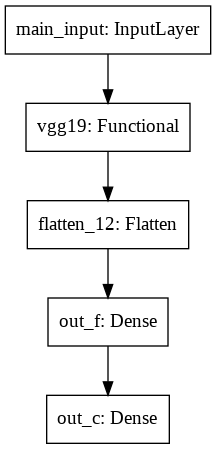

In [15]:
def get_model3(pi=0.5):
    # Conv base
    in_layer = Input(shape=image_size, name='main_input')
    conv_base = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")(in_layer)
    conv_base = Flatten()(conv_base)    
    # fine output 
    out_f = Dense(num_classes_f, activation="softmax", name='out_f')(conv_base)
    # coarse output
    out_c = Dense(num_classes_c, activation="softmax", name='out_c')(out_f)
    # Build the model
    model = Model(name='Model_3',
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[1-pi, pi],
                  metrics=['accuracy'])
    return model

model = get_model3()
model.summary()
plot_model(model)

Model: "Model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
logits_c (Dense)                (None, 20)           10260       flatten_3[0][0]                  
____________________________________________________________________________________________

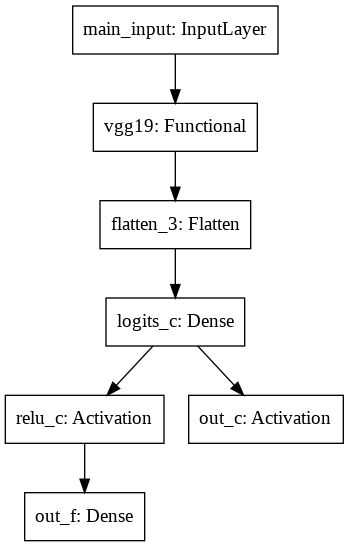

In [7]:
def get_model4(pi=0.5):
    # Conv base
    in_layer = Input(shape=image_size, name='main_input')
    conv_base = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")(in_layer)
    conv_base = Flatten()(conv_base)
    # coarse output
    logits_c = Dense(num_classes_c, name='logits_c')(conv_base)
    out_c = Activation(keras.activations.softmax, name='out_c')(logits_c)
    
    # fine output 
    relu_c = Activation(keras.activations.relu, name='relu_c')(logits_c)
    out_f = Dense(num_classes_f, activation="softmax", name='out_f')(relu_c)
    # Build the model
    model = Model(name='Model_4',
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[1-pi, pi],
                  metrics=['accuracy'])
    return model

model = get_model4()
model.summary()
plot_model(model)


Model: "Model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
logits_f (Dense)                (None, 100)          51300       flatten_4[0][0]                  
____________________________________________________________________________________________

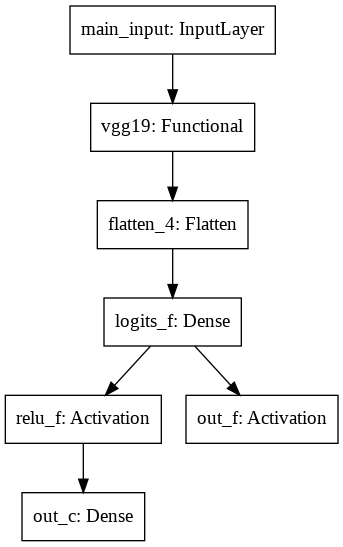

In [8]:
def get_model5(pi=0.5):
    # Conv base
    in_layer = Input(shape=image_size, name='main_input')
    conv_base = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")(in_layer)
    conv_base = Flatten()(conv_base)
    # coarse output
    logits_f = Dense(num_classes_f, name='logits_f')(conv_base)
    relu_f = Activation(keras.activations.relu, name='relu_f')(logits_f)
    out_c = Dense(num_classes_c, activation="softmax", name='out_c')(relu_f)
    # fine output 
    out_f = Activation(keras.activations.softmax, name='out_f')(logits_f)
    # Build the model
    model = Model(name='Model_5',
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[1-pi, pi],
                  metrics=['accuracy'])
    return model

model = get_model5()
model.summary()
plot_model(model)


Model: "Model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19_1 (Functional)            (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
vgg19_2 (Functional)            (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 512)          0           vgg19_1[0][0]                    
____________________________________________________________________________________________

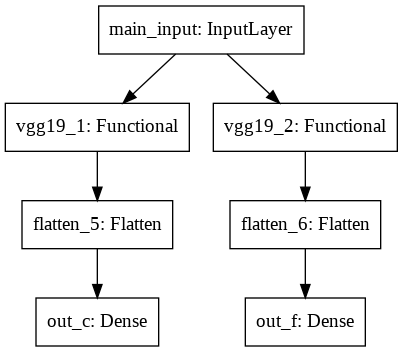

In [9]:
def get_model6(pi=0.5):
    # Conv base
    conv_base1 = keras.applications.VGG19(
    include_top=False,
    weights="imagenet")
    conv_base1._name = 'vgg19_1'
    conv_base2 = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")
    conv_base2._name = 'vgg19_2'
    in_layer = Input(shape=image_size, name='main_input')
    conv_base1 = conv_base1(in_layer)    
    conv_base1 = Flatten()(conv_base1)

    conv_base2 = conv_base2(in_layer)
    conv_base2 = Flatten()(conv_base2)
    # coarse output
    out_c = Dense(num_classes_c, activation="softmax", name='out_c')(conv_base1)
    # fine output 
    out_f = Dense(num_classes_f, activation="softmax", name='out_f')(conv_base2)
    # Build the model
    model = Model(name='Model_6',
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[1-pi, pi],
                  metrics=['accuracy'])
    return model

model = get_model6()
model.summary()
plot_model(model)

Model: "Model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_7 (Flatten)             (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
out_c (Dense)                   (None, 20)           10260       flatten_7[0][0]                  
____________________________________________________________________________________________

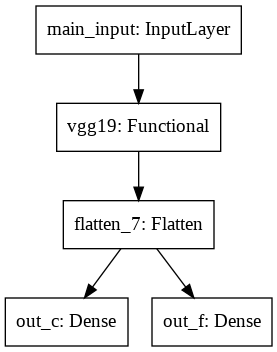

In [10]:
# Create the model
model1_pi1 = get_model1(1)
model1_pi1.summary()

#train model
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
global_accuracy_callback = global_accuracy(X_val, y_val)
batch = 128
history = model1_pi1.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=20,
                    callbacks=[tensorboard_callback, global_accuracy_callback])
plot_model(model1_pi1)

# model.evaluate(X_test, y_test)


Model: "Model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_8 (Flatten)             (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
out_c (Dense)                   (None, 20)           10260       flatten_8[0][0]                  
____________________________________________________________________________________________

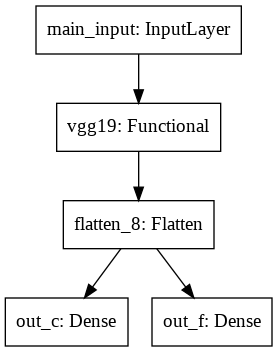

In [11]:
# Create the model
model1_pi0 = get_model1(0)
model1_pi0.summary()
#train model
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
global_accuracy_callback = global_accuracy(X_val, y_val)
batch = 128
history = model1_pi0.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=20,
                    callbacks=[tensorboard_callback, global_accuracy_callback])
plot_model(model1_pi0)



Model: "Model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_9 (Flatten)             (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
out_c (Dense)                   (None, 20)           10260       flatten_9[0][0]                  
____________________________________________________________________________________________

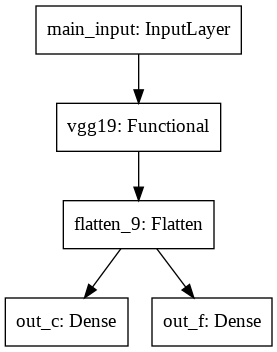

In [12]:
# Create the model
model1_pi0_5 = get_model1(0.5)
model1_pi0_5.summary()
#train model
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
global_accuracy_callback = global_accuracy(X_val, y_val)
batch = 128
history = model1_pi0_5.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=20,
                    callbacks=[tensorboard_callback, global_accuracy_callback])

plot_model(model1_pi0_5)


Model: "Model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_10 (Flatten)         (None, 512)               0         
_________________________________________________________________
out_c (Dense)                (None, 20)                10260     
_________________________________________________________________
out_f (Dense)                (None, 100)               2100      
Total params: 20,036,744
Trainable params: 20,036,744
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
391/391 [==============================] - 17s 41ms/step - loss: 3.9718 - out_c_loss: 3.3378 - out_f_l

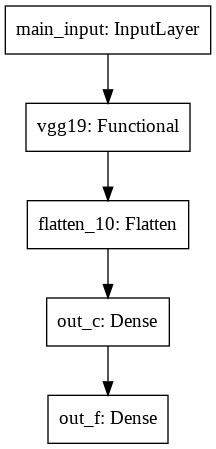

In [13]:
# Create the model
model2 = get_model2(0.5)
model2.summary()
#train model
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
global_accuracy_callback = global_accuracy(X_val, y_val)
batch = 128
history = model2.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=20,
                    callbacks=[tensorboard_callback, global_accuracy_callback])
plot_model(model2)



Model: "Model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_12 (Flatten)         (None, 512)               0         
_________________________________________________________________
out_f (Dense)                (None, 100)               51300     
_________________________________________________________________
out_c (Dense)                (None, 20)                2020      
Total params: 20,077,704
Trainable params: 20,077,704
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
391/391 [==============================] - 17s 42ms/step - loss: 4.1174 - out_c_loss: 2.9957 - out_f_l

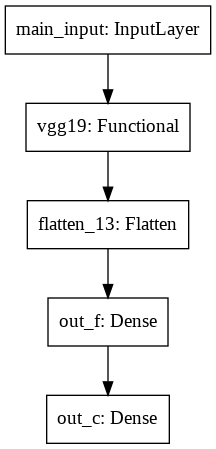

In [16]:
# Create the model
model3 = get_model3(0.5)
model.summary()
#train model
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
global_accuracy_callback = global_accuracy(X_val, y_val)
batch = 128
history = model3.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=20,
                    callbacks=[tensorboard_callback, global_accuracy_callback])

plot_model(model3)


Model: "Model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_14 (Flatten)            (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
logits_c (Dense)                (None, 20)           10260       flatten_14[0][0]                 
____________________________________________________________________________________________

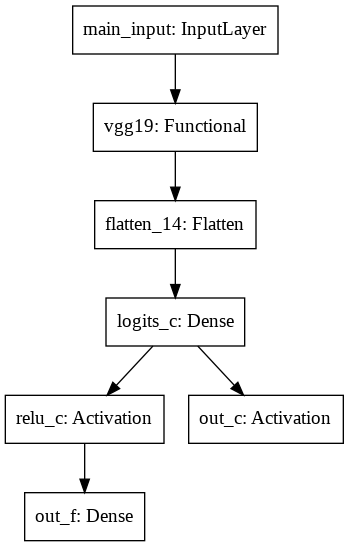

In [17]:
# Create the model
model4 = get_model4(0.5)
model4.summary()
#train model
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
global_accuracy_callback = global_accuracy(X_val, y_val)
batch = 128
history = model4.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=20,
                    callbacks=[tensorboard_callback, global_accuracy_callback])

plot_model(model4)


Model: "Model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_15 (Flatten)            (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
logits_f (Dense)                (None, 100)          51300       flatten_15[0][0]                 
____________________________________________________________________________________________

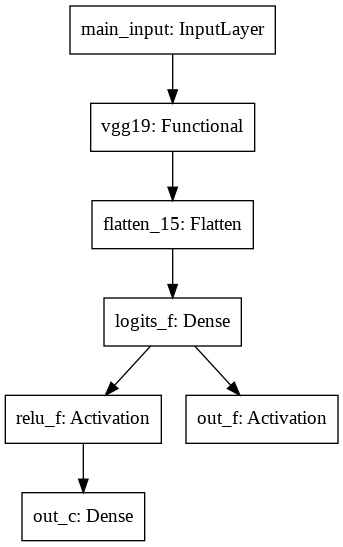

In [18]:
# Create the model
model5 = get_model5(0.5)
model5.summary()
#train model
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
global_accuracy_callback = global_accuracy(X_val, y_val)
batch = 128
history = model5.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=20,
                    callbacks=[tensorboard_callback, global_accuracy_callback])

plot_model(model5)


Model: "Model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19_1 (Functional)            (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
vgg19_2 (Functional)            (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_16 (Flatten)            (None, 512)          0           vgg19_1[0][0]                    
____________________________________________________________________________________________

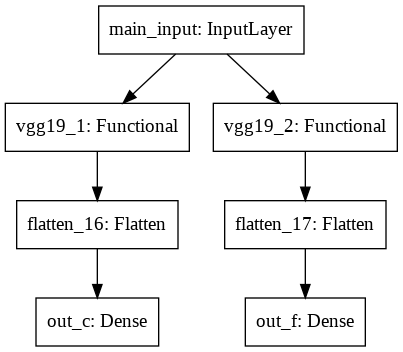

In [19]:
# Create the model
model6 = get_model6(0.5)
model6.summary()
#train model
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
global_accuracy_callback = global_accuracy(X_val, y_val)
batch = 128
history = model6.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=20,
                    callbacks=[tensorboard_callback, global_accuracy_callback])
plot_model(model6)



In [83]:
data = pd.DataFrame(columns=['algo','accuracy','accuracy_c', 'accuracy_f'])

accuracy, accuracy_c, accuracy_f = get_metrics(model1_pi1, X_test, y_test)
data_list = list(zip(['model1_pi1']*len(accuracy), accuracy, accuracy_c, accuracy_f))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f']),ignore_index=True)

accuracy, accuracy_c, accuracy_f = get_metrics(model1_pi0, X_test, y_test)
data_list = list(zip(['model1_pi0']*len(accuracy), accuracy, accuracy_c, accuracy_f))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f']),ignore_index=True)

accuracy, accuracy_c, accuracy_f = get_metrics(model1_pi0_5, X_test, y_test)
data_list = list(zip(['model1_pi0.5']*len(accuracy), accuracy, accuracy_c, accuracy_f))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f']),ignore_index=True)

accuracy, accuracy_c, accuracy_f = get_metrics(model2, X_test, y_test)
data_list = list(zip(['model2']*len(accuracy), accuracy, accuracy_c, accuracy_f))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f']),ignore_index=True)

accuracy, accuracy_c, accuracy_f = get_metrics(model3, X_test, y_test)
data_list = list(zip(['model3']*len(accuracy), accuracy, accuracy_c, accuracy_f))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f']),ignore_index=True)

accuracy, accuracy_c, accuracy_f = get_metrics(model4, X_test, y_test)
data_list = list(zip(['model4']*len(accuracy), accuracy, accuracy_c, accuracy_f))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f']),ignore_index=True)

accuracy, accuracy_c, accuracy_f = get_metrics(model5, X_test, y_test)
data_list = list(zip(['model5']*len(accuracy), accuracy, accuracy_c, accuracy_f))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f']),ignore_index=True)

accuracy, accuracy_c, accuracy_f = get_metrics(model6, X_test, y_test)
data_list = list(zip(['model6']*len(accuracy), accuracy, accuracy_c, accuracy_f))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f']),ignore_index=True)



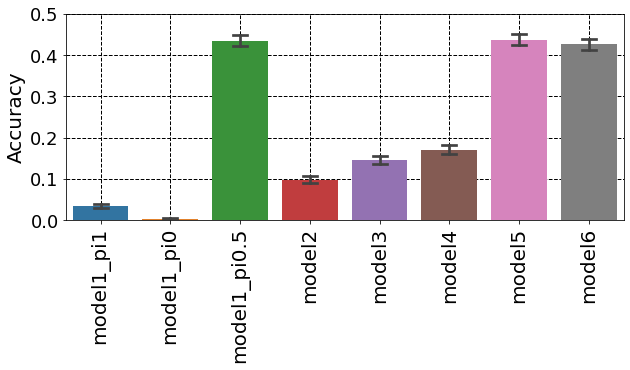

In [84]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(10, 3.8))

ax = sns.barplot(x="algo", y="accuracy", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("Accuracy")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.0, 0.5)
plt.xticks(rotation=90)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

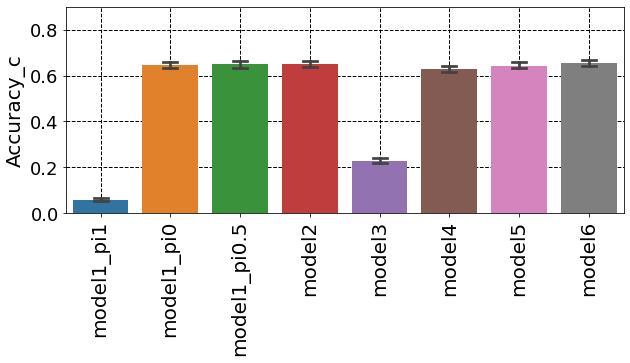

In [85]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(10, 3.8))

ax = sns.barplot(x="algo", y="accuracy_c", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("Accuracy_c")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.0, 0.9)
plt.xticks(rotation=90)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

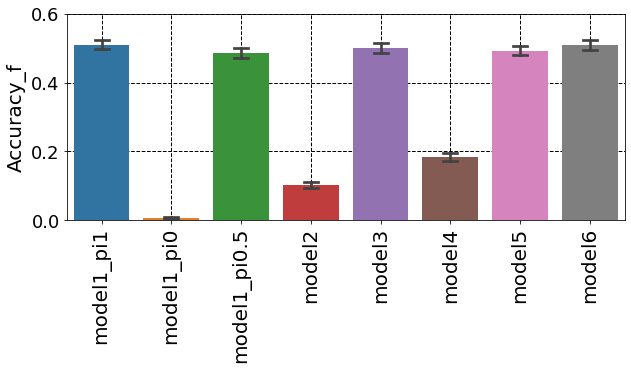

In [86]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(10, 3.8))

ax = sns.barplot(x="algo", y="accuracy_f", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("Accuracy_f")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.0, 0.6)
plt.xticks(rotation=90)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

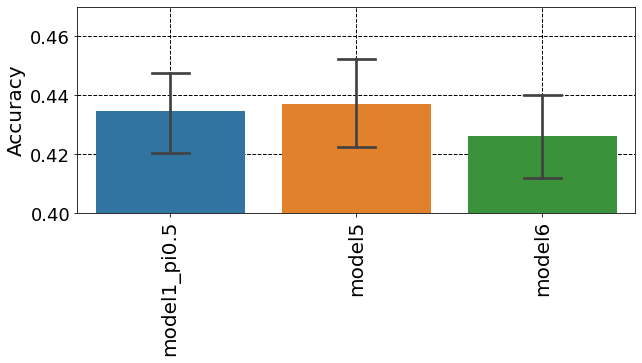

In [87]:
data_ = data[data.algo.isin(['model1_pi0.5', 'model5', 'model6'])]
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(10, 3.8))

ax = sns.barplot(x="algo", y="accuracy", data=data_, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("Accuracy")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.4, 0.47)
plt.xticks(rotation=90)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

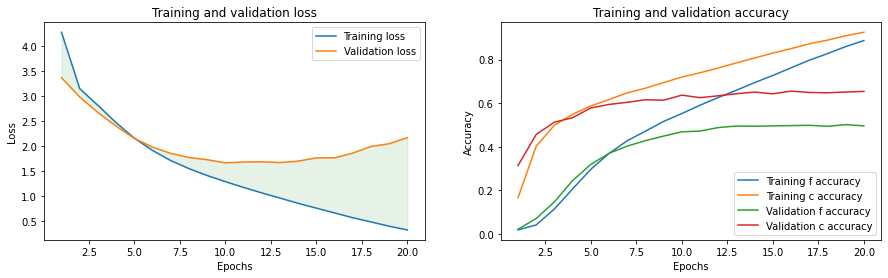

In [21]:
out_f_accuracy = history.history['out_f_accuracy']
out_c_accuracy = history.history['out_c_accuracy']
val_out_f_accuracy = history.history['val_out_f_accuracy']
val_out_c_accuracy = history.history['val_out_c_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(15,4))

ax1 = plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.fill_between(epochs, loss,val_loss,color='g',alpha=.1)

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

ax2 = plt.subplot(1, 2, 2)
plt.plot(epochs, out_f_accuracy, label='Training f accuracy')
plt.plot(epochs, out_c_accuracy, label='Training c accuracy')
plt.plot(epochs, val_out_f_accuracy, label='Validation f accuracy')
plt.plot(epochs, val_out_c_accuracy, label='Validation c accuracy')
# plt.fill_between(epochs, acc,val_acc,color='g',alpha=.1)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()